## Variational Autoencoder

A variational autoencoder is a generative neural network model consisting of an encoder, a sampling layer and a decoder. Autoencoders are generally used to learn a latent representation of data by creating an information bottleneck through a pyramid-like structure of the encoder where each layers has fewer degrees of freedom compared to the previous layer. This results in dimensionality reduction of the input. The decoder on the other hand takes a compressed latent representation and reconstructs the original input. In order to make an autoencoder generative, we learn a variational approximation of the hidden layer.

<img src=".\figures\vae_model.png">

Autoencoders are data driven and application specific, for example an autoencoder trained on digits will not perform well on images of faces. Autoencoders result in lossy compression. They are useful in data denoising and dimensionality reduction. Training variational autoencoders consists of optimizing a custom loss function consisting of reconstruction loss and regularization loss:

\begin{equation}
    \min H(p,q) + KL(z||pz)
\end{equation}

where $H(p,q)$ is the cross-entropy reconstruction loss defined as $-\sum_i p_i \log q_i$ where $p$ is the ground truth distribution and $q$ is the predicted distribution and $KL(q||z)$ is the regularization loss that constraints our variational approximation $z$ to be close to our prior $pz \sim N(0,1)$ which is assumed to be a standard normal in our example. The regularization loss forces similar inputs to be close in the latent space. In variational autoencoder, we learn the variational approximation parameters ($\mu$ and $\log \sigma$) using the neural network. Thus, we can construct our approximate distribution $z$ as follows:

\begin{equation}
    z = \mu + \exp(\log \sigma) \times N(0,1)
\end{equation}

As we'll see in the following example, we'll be able to generate an image manifold by sampling from our distribution $z \sim N(\mu, \sigma^2)$ above and feeding the samples through a decoder to generate an image.

In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
from scipy.stats import norm

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In training variational autoencoder, we'll use a learning rate schedule that divides the initial learning rate by 2 every fixed number of epochs, we'll also use a callback to monitor the learning rate.

In [4]:
DATA_PATH = '/data/vision/fisher/data1/vsmolyakov/vae/'

def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

Let's load the data and define training and model parameters:

In [6]:
#load data
print "loading data..."
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#training params
batch_size = 100
num_epochs = 128 

#model params
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epsilon_std = 1.0

loading data...


We'll implement the sampling layer using a Lambda layer in Keras.

In [7]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

Let's define the variational autoencoder architecture:

In [8]:
#VAE architecture
#encoder
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

Because our loss function consists of two terms, we have to define a custom loss layer:

In [10]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        return x


We can finally compile our variational autoencoder model using Adam optimizer:

In [11]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             514         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             514         dense_1[0][0]                    
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  """


In [12]:
#define callbacks
file_name = DATA_PATH + 'weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, tensor_board, hist_lr, reduce_lr, early_stopping]


In [13]:
print "training vae model..."
hist = vae.fit(x_train, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test, None), verbose=2)

training vae model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/128
Epoch 00000: loss improved from inf to 207.46185, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 207.4619 - val_loss: 181.7194
Epoch 2/128
Epoch 00001: loss improved from 207.46185 to 175.27829, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 175.2783 - val_loss: 170.4656
Epoch 3/128
Epoch 00002: loss improved from 175.27829 to 168.62863, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 168.6286 - val_loss: 166.0275
Epoch 4/128
Epoch 00003: loss improved from 168.62863 to 165.28341, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 165.2834 - val_loss: 163.8910
Epoch 5/128
Epoch 00004: loss improved from 165.28341 to 163.33535, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 163.3354 - val

10s - loss: 147.3806 - val_loss: 150.1782
Epoch 44/128
Epoch 00043: loss improved from 147.38060 to 147.32383, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
10s - loss: 147.3238 - val_loss: 150.2023
Epoch 45/128
Epoch 00044: loss improved from 147.32383 to 147.23673, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
10s - loss: 147.2367 - val_loss: 150.0926
Epoch 46/128
Epoch 00045: loss improved from 147.23673 to 147.17098, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 147.1710 - val_loss: 150.0273
Epoch 47/128
Epoch 00046: loss improved from 147.17098 to 147.11243, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 147.1124 - val_loss: 149.9769
Epoch 48/128
Epoch 00047: loss improved from 147.11243 to 146.86245, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
9s - loss: 146.8624 - val_loss: 149.8431
E

10s - loss: 145.7868 - val_loss: 149.6104
Epoch 89/128
Epoch 00088: loss improved from 145.78678 to 145.77177, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
10s - loss: 145.7718 - val_loss: 149.6495
Epoch 90/128
Epoch 00089: loss did not improve
9s - loss: 145.7738 - val_loss: 149.5923
Epoch 91/128
Epoch 00090: loss improved from 145.77177 to 145.76849, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
10s - loss: 145.7685 - val_loss: 149.5719
Epoch 92/128
Epoch 00091: loss improved from 145.76849 to 145.74702, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
10s - loss: 145.7470 - val_loss: 149.6446
Epoch 93/128
Epoch 00092: loss did not improve
9s - loss: 145.7517 - val_loss: 149.5809
Epoch 94/128
Epoch 00093: loss improved from 145.74702 to 145.72771, saving model to /data/vision/fisher/data1/vsmolyakov/vae/weights-checkpoint.hdf5
11s - loss: 145.7277 - val_loss: 149.6039
Epoch 95/128
E

Let's save the model and final weights, we can then load the saved model as follows:

In [15]:
vae.save(DATA_PATH + 'final_model.h5', overwrite=True)
vae.save_weights(DATA_PATH + 'final_weights.h5', overwrite=True)

#load saved model
#vae = load_model(DATA_PATH + 'final_model.h5')

In [16]:
encoder = Model(x, z_mean)

#generative model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Let's visualize our training loss and the learning rate:

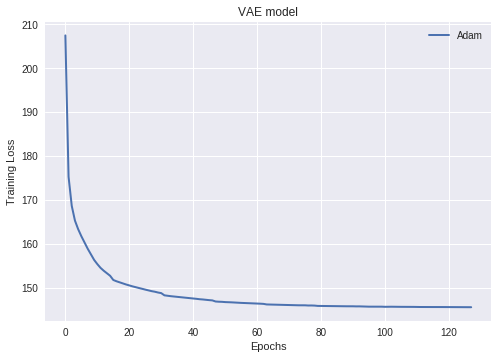

In [17]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, label='Adam')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/vae_training_loss.png')


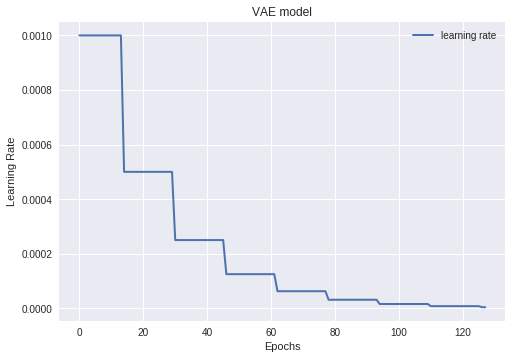

In [18]:
plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/vae_learning_rate.png')


We see a staircase pattern in the learning rate caused by a division by 2 of the initial learning rate every 16 epochs as desired.

Finally, we can scan the latent space to generate a manifold of images learned by the variational autoencoder. Since we know that our variational approximation $z \sim N(\mu, \sigma^2)$ is close to $N(0,1)$ due to the regularization loss, we can define a grid of dimension $h=2$ centered at zero and for each sample in that grid generate an image by feeding our samples through a decoder.

In [19]:
n = 15 #number of samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i+1) * digit_size,
               j * digit_size: (j+1) * digit_size] = digit


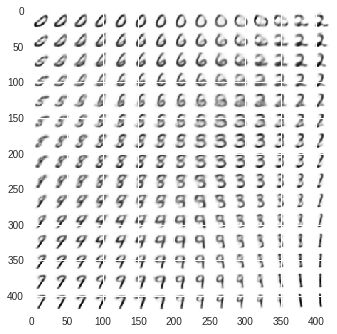

In [20]:
plt.figure()
plt.imshow(figure)
plt.savefig('./figures/vae_manifold.png')

## References
[1] D. Kingma et al., "Auto-Encoding Variational Bayes", ICLR 2014  
[2] F. Chollet, "Keras Blog", https://blog.keras.io/